# Group 21  - Chess Piece Classification
## Deep Learning Project


|      |     Student Name     |     Student Email    | 
|---   |         ---          |           ---          |
| 1    |      Ana Miguel Sal       |20221645@novaims.unl.pt| 
| 2    |      David Castro      |          20220688@novaims.unl.pt    | 
| 3    |      Ehis Jegbefumwen        |20221015@novaims.unl.pt| 
| 4    |      Evans Onorieru|        20220657@novaims.unl.pt     | 
| 5    |      Ricardo Montenegro      |20221359@novaims.unl.pt| 

### Data Source
https://www.kaggle.com/datasets/s4lman/chess-pieces-dataset-85x85

### Abstract

This file presents the model handcrafted created to solve chess piece classification problem. We applied seven different models to our problem, adding more stacks of layers, changing the number of kernels per layer and the kernel windows, adding dropout layer and batch normalization, applying the L2 regularization technique and testing the model with different learning rates and optimizers.

Finally the best solution we got was a model with three sets of convolutional layers with increasing number of filters. Each convolutional layer applies a set of filters with a size of 3x3, and the activation function used is the Rectified Linear Unit (ReLU) for the hidden layer and softmax for the output layer. After each set of convolutional layers, a max-pooling layer was applied. To prevent overfitting, a dropout layer is applied after the fully connected layer with a dropout rate of 0.5. When fitting the model we used the Adam optimizer and a learning rate of 0.001.
With this architecture we got 89% of accuracy on the training data and 72% on the test data.

## 1. Imports

In [1]:
import time
import shutil
import zipfile

from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics, losses
import numpy as np

import os
from PIL import Image, ImageEnhance
import glob
import random

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory 
import tensorflow as tf

import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Load Images

In [2]:
# Set the machine
gdrive = True
# Set the connection string
path = '/content/drive/MyDrive/NOVA IMS/DL/project/'
main_folder = "data/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'archive.zip', 'archive.zip')
    # Extract files
    zip_ = zipfile.ZipFile('archive.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 2.340 seconds


## 3. Data Preprocessing

*   Data Augmentation
*   Save those new images to create a new balanced dataset



In [3]:
# Creation of an augmentation pipeline

augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.25),
                           layers.RandomBrightness(factor=0.2),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

Create a function that loops for each image in each of the subfolders and create a modify version of each image (trials) times. Then each of the new image created is then saved in the same folder of the existing original image.

In [4]:

def augment_images(folder_path, trials):
    # create an instance of the image data generator with your augmentation pipeline
    datagen = ImageDataGenerator(preprocessing_function=augmentation)

    # get a list of all image filenames in the folder
    image_filenames = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    # loop through each image file
    for filename in image_filenames:
        # open the image file
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as image:
            # expand the image dimension and apply augmentation pipeline 'trials' times
            x = np.expand_dims(np.array(image), axis=0)
            for i in range(trials):
                # generate an augmented image
                augmented_image = datagen.flow(x, batch_size=1)[0][0]

                # save the augmented image with a new filename
                new_filename = f'{os.path.splitext(filename)[0]}_augmented_{i}.jpg'
                new_image_path = os.path.join(folder_path, new_filename)
                Image.fromarray(augmented_image.astype('uint8')).save(new_image_path)

    print('Image augmentation complete!')


Run this function for all subfolders, except for the 'pawn' folder.

In [5]:
augment_images('/content/data/bishop', 4)
augment_images('/content/data/king', 7)
augment_images('/content/data/knight', 4)
augment_images('/content/data/queen', 7)
augment_images('/content/data/rook', 4)


Image augmentation complete!
Image augmentation complete!
Image augmentation complete!
Image augmentation complete!
Image augmentation complete!


Count how many images each subfolder has:

In [6]:
# Set the path to the dataset directory
dataset_path = path + main_folder

# Get a list of subdirectories (i.e., class folders) in the dataset directory
subdirs = glob.glob(os.path.join(dataset_path, '*'))

# Loop through each subdirectory and count the number of images
for subdir in subdirs:
    num_images = len(os.listdir(subdir))
    print('Class {}: {} images'.format(os.path.basename(subdir), num_images))

Class queen: 272 images
Class bishop: 335 images
Class knight: 355 images
Class pawn: 239 images
Class king: 272 images
Class rook: 360 images


Limit all subfolder to a maximum of 239 images, randomly sorted.

In [7]:
# set the path to the folder containing the class folders
parent_folder = '/content/data/'

# set the desired number of images for each class
num_images_per_class = 239

# loop through each class folder
for class_folder in os.listdir(parent_folder):
    # set the path to the current class folder
    class_folder_path = os.path.join(parent_folder, class_folder)
    # check if it is a folder and not a file
    if os.path.isdir(class_folder_path):
        # get a list of all image filenames in the folder
        image_filenames = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        # shuffle the image filenames
        random.shuffle(image_filenames)
        # loop through the excess images and remove them
        for filename in image_filenames[num_images_per_class:]:
            file_path = os.path.join(class_folder_path, filename)
            os.remove(file_path)
        # print the number of images remaining in the folder
        num_images = len(os.listdir(class_folder_path))
        print(f'Class {class_folder}: {num_images} images')
print('Our dataset is now balanced!')


Class queen: 239 images
Class bishop: 239 images
Class knight: 239 images
Class pawn: 239 images
Class king: 239 images
Class rook: 239 images
Our dataset is now balanced!


## 4. Changing the architecture of the dataset - Train and Test Split

1.   Train and validation Split
2.   Set ds_train, ds_val, ds_test



Split the image dataset into Train and Test data by changing organization/structure of the folders.

In [8]:
# Set path to your data folder
data_path = path + main_folder

# Set path to your destination folder
destination_path = path

# Set test data size (fraction)
test_size = 0.2

# Create destination folders
train_path = os.path.join(destination_path, "training_data")
os.makedirs(train_path, exist_ok=True)

test_path = os.path.join(destination_path, "testing_data")
os.makedirs(test_path, exist_ok=True)

# Loop through each class folder in data folder
for class_folder in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_folder)

    # Split files into train and test sets
    files = os.listdir(class_folder_path)
    train_files, test_files = train_test_split(files, test_size=test_size)

    # Copy train files to destination folder
    train_class_folder = os.path.join(train_path, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    for file_name in train_files:
        file_path = os.path.join(class_folder_path, file_name)
        shutil.copy(file_path, train_class_folder)

    # Copy test files to destination folder
    test_class_folder = os.path.join(test_path, class_folder)
    os.makedirs(test_class_folder, exist_ok=True)
    for file_name in test_files:
        file_path = os.path.join(class_folder_path, file_name)
        shutil.copy(file_path, test_class_folder)


Confirm if the cell above was successfully acomplished.

In [9]:
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    print(f"Train - {folder}: {len(os.listdir(folder_path))} files")

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    print(f"Test - {folder}: {len(os.listdir(folder_path))} files")


Train - queen: 191 files
Train - bishop: 191 files
Train - knight: 191 files
Train - pawn: 191 files
Train - king: 191 files
Train - rook: 191 files
Test - queen: 48 files
Test - bishop: 48 files
Test - knight: 48 files
Test - pawn: 48 files
Test - king: 48 files
Test - rook: 48 files


Defines a list of parameters for the ``image_dataset_from_directory``.

In [10]:
image_size=(85, 85)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the ``image_dataset_from_directory`` function. Performs an automatic split in training and validation data via ``validation_split``. Note that by assigning value to the ``validation_split`` parameter, the ``image_dataset_from_directory()`` function will split the training data.

In [11]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory('/content/training_data', 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1146 files belonging to 6 classes.
Using 917 files for training.
Using 229 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']


Creating an iterator 'iter_train' for the training dataset.

In [12]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 85, 85, 3) (64, 6)

Sample of x_train: tf.Tensor(
[[106. 108.]
 [109. 107.]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]], shape=(5, 6), dtype=float32)
Sample average of y_train: tf.Tensor(0.16666667, shape=(), dtype=float32)


Plot images loaded with ``BatchDataset``.

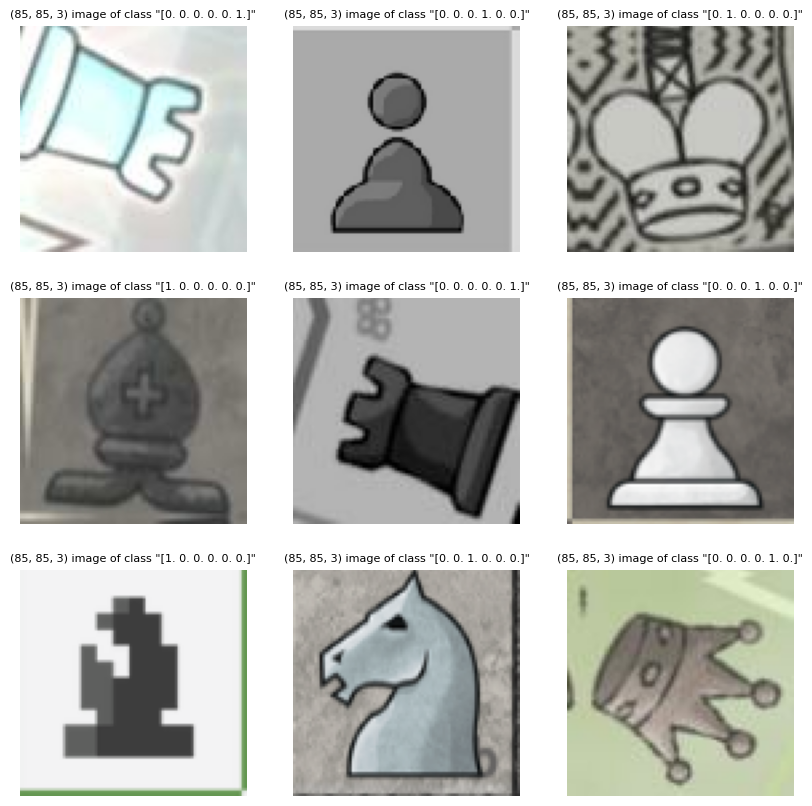

In [13]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

Loads the testing data using the ``image_dataset_from_directory()`` function.

In [14]:
ds_test = image_dataset_from_directory('/content/testing_data', 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 288 files belonging to 6 classes.


## 5. Convolutional neural networks (CNNs) in Keras

In [15]:
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 85, 85, 3)

### 5.1 CNN - V1

We will start with the following architecture:

In [16]:
# Architecture V1
cnn1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], kernel_size=(5, 5), #input_shape=input_shape[1:],
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=16*input_shape[-1], kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=6, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1")
# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1.build(input_shape)
# Check network
cnn1.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

Model: "CNN-V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 81, 18)        1368      
                                                                 
 activation (Activation)     (None, 81, 81, 18)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 36, 36, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 48)       0         
 2D)                                                        

Compiles the model for training.

In [17]:
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1.compile(loss=losses.CategoricalCrossentropy(),
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])

Fits the model on ``ds_train``. Uses ``ds_val`` for validation.

In [18]:
# Model training (V1)
epochs = 5
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 16s 979ms/step - loss: 48.8072 - accuracy: 0.2116 - AUROC: 0.5144 - val_loss: 2.0305 - val_accuracy: 0.2882 - val_AUROC: 0.6355
Epoch 2/5
15/15 [==============================] - 14s 929ms/step - loss: 1.6032 - accuracy: 0.3904 - AUROC: 0.7271 - val_loss: 1.7135 - val_accuracy: 0.3843 - val_AUROC: 0.7386
Epoch 3/5
15/15 [==============================] - 16s 1s/step - loss: 1.3193 - accuracy: 0.5038 - AUROC: 0.8181 - val_loss: 1.6445 - val_accuracy: 0.3974 - val_AUROC: 0.7100
Epoch 4/5
15/15 [==============================] - 14s 918ms/step - loss: 1.0410 - accuracy: 0.5987 - AUROC: 0.8874 - val_loss: 1.5271 - val_accuracy: 0.4803 - val_AUROC: 0.8029
Epoch 5/5
15/15 [==============================] - 13s 840ms/step - loss: 0.7778 - accuracy: 0.7219 - AUROC: 0.9393 - val_loss: 1.6956 - val_accuracy: 0.4017 - val_AUROC: 0.7413


Plots the learning curves.

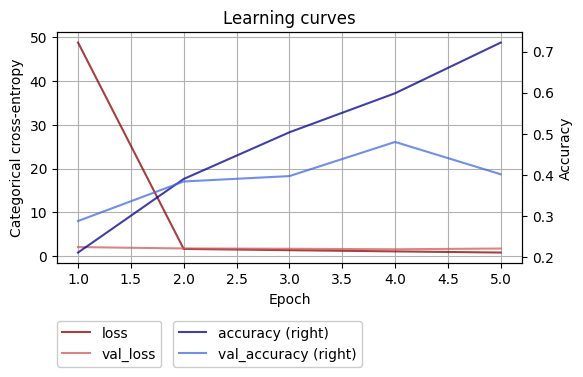

In [19]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** the best results were at epoch 4, where we have less than 1.6 both of cross-entropy and 60% of accuracy for the train dataset and 48% of accuracy for the validation dataset. At this epoch the validation accuracy was the highest and the gap between train and validation accuracy was fewer when compared with epoch 5.

### 5.2 CNN - V2

Consider a modified architecture, called CNN-V2, with input pixels' scaling.

In [20]:
# Architecture V2
cnn2 = Sequential([# The input layer
                   layers.Input(input_shape[1:]),    
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=16*input_shape[-1], kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=6, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2")
# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
#cnn2.build(input_shape)
# Check network
cnn2.summary()  # alternatively use tf.keras.utils.plot_model(cnn2, show_shapes=True)

Model: "CNN-V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 85, 85, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 81, 81, 18)        1368      
                                                                 
 activation_2 (Activation)   (None, 81, 81, 18)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 40, 40, 18)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 48)        21648     
                                                                 
 activation_3 (Activation)   (None, 36, 36, 48)        0         
                                                            

Compiles and fits the model.

In [21]:
# Compile the model
cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 5
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 14s 909ms/step - loss: 1.8804 - accuracy: 0.2432 - AUROC: 0.5568 - val_loss: 1.6749 - val_accuracy: 0.2969 - val_AUROC: 0.6790
Epoch 2/5
15/15 [==============================] - 14s 947ms/step - loss: 1.5383 - accuracy: 0.3817 - AUROC: 0.7345 - val_loss: 2.8863 - val_accuracy: 0.1572 - val_AUROC: 0.6214
Epoch 3/5
15/15 [==============================] - 14s 957ms/step - loss: 1.3888 - accuracy: 0.4733 - AUROC: 0.8011 - val_loss: 1.3818 - val_accuracy: 0.4148 - val_AUROC: 0.7674
Epoch 4/5
15/15 [==============================] - 14s 959ms/step - loss: 1.1708 - accuracy: 0.5267 - AUROC: 0.8515 - val_loss: 1.1656 - val_accuracy: 0.5546 - val_AUROC: 0.8427
Epoch 5/5
15/15 [==============================] - 14s 925ms/step - loss: 1.1326 - accuracy: 0.5420 - AUROC: 0.8632 - val_loss: 1.2527 - val_accuracy: 0.4410 - val_AUROC: 0.8098


Plots the learning curves.

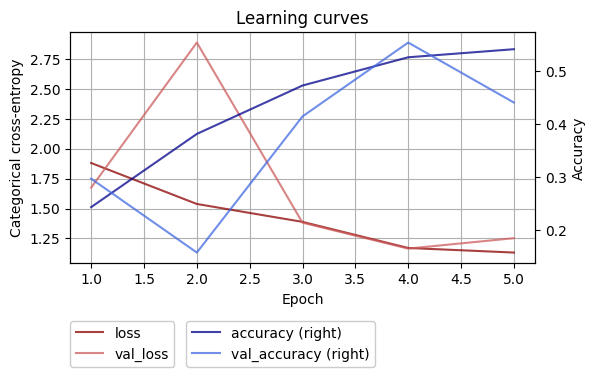

In [22]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** at epoch 4 we have both cross-entropy less than 1.2 of and 53% of accuracy for the train dataset and 56% of accuracy for the validation dataset.
This has similar results to the CNN-V1, although it has now less cross-entropy, less accuracy for the training set but more accuracy for the validation set.

### 5.3 CNN - V3

In this modified version, we've added three additional stacks of convolutional and pooling layers, followed by a fully connected layer with 256 units and a dropout layer to help prevent overfitting. 

In [23]:
# Architecture V3 with additional layers
cnn3 = Sequential([
                   layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Flatten(),
                   layers.Dense(units=256, activation="relu"),
                   layers.Dropout(0.5),
                   layers.Dense(units=6, activation="softmax")],
                   name="CNN-V3")
cnn3.summary()

Model: "CNN-V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 85, 85, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 85, 85, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                        

Compiles and fits the model.

In [24]:
# Compile the model
cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 5
history2 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 64s 4s/step - loss: 15.5475 - accuracy: 0.1897 - AUROC: 0.5092 - val_loss: 1.7681 - val_accuracy: 0.2402 - val_AUROC: 0.5656
Epoch 2/5
15/15 [==============================] - 59s 4s/step - loss: 1.6594 - accuracy: 0.3119 - AUROC: 0.6592 - val_loss: 2.0705 - val_accuracy: 0.1921 - val_AUROC: 0.5242
Epoch 3/5
15/15 [==============================] - 57s 4s/step - loss: 1.5414 - accuracy: 0.3370 - AUROC: 0.7152 - val_loss: 1.3998 - val_accuracy: 0.4061 - val_AUROC: 0.7653
Epoch 4/5
15/15 [==============================] - 61s 4s/step - loss: 1.3084 - accuracy: 0.4558 - AUROC: 0.8041 - val_loss: 1.3219 - val_accuracy: 0.4454 - val_AUROC: 0.7994
Epoch 5/5
15/15 [==============================] - 60s 4s/step - loss: 1.3589 - accuracy: 0.4766 - AUROC: 0.8036 - val_loss: 1.4877 - val_accuracy: 0.4978 - val_AUROC: 0.7969


Plotting the Learning Curves

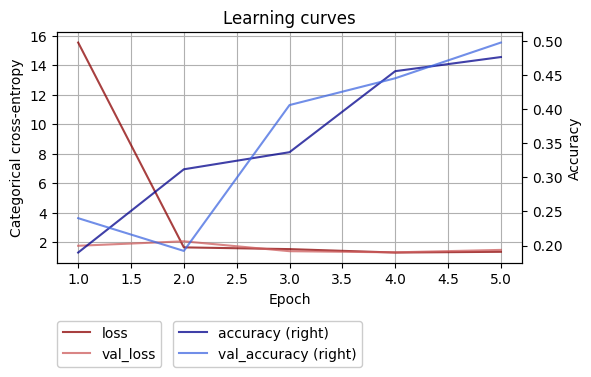

In [25]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** at epoch 5 we have both cross-entropy less than 1.5 and 48% of accuracy for the train dataset and 50% of accuracy for the validation dataset.
The results are very similar to the ones in CNN-V2 but it´s slightly worse than the CNN-V2.

### 5.4 CNN - V4

Now we will use the architecture used in V3 but with a different compile optimizer. Test with [Adam, Adagrad, Adadelta, SGD, Nadam]

In [26]:
# Architecture V3 with additional layers
cnn4 = Sequential([
                   layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Flatten(),
                   layers.Dense(units=256, activation="relu"),
                   layers.Dropout(0.5),
                   layers.Dense(units=6, activation="softmax")],
                   name="CNN-V4")
cnn4.summary()

Model: "CNN-V4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 85, 85, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 85, 85, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 42, 42, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                        

Compiles and fits the model.

In [27]:
# Compile the model with the Adam optimizer
cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 5
history2 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_val)


Epoch 1/5
15/15 [==============================] - 62s 4s/step - loss: 16.6129 - accuracy: 0.1712 - AUROC: 0.5019 - val_loss: 1.7841 - val_accuracy: 0.2664 - val_AUROC: 0.5708
Epoch 2/5
15/15 [==============================] - 60s 4s/step - loss: 1.7667 - accuracy: 0.2312 - AUROC: 0.5855 - val_loss: 1.7294 - val_accuracy: 0.2052 - val_AUROC: 0.6305
Epoch 3/5
15/15 [==============================] - 60s 4s/step - loss: 1.6913 - accuracy: 0.2792 - AUROC: 0.6358 - val_loss: 1.5311 - val_accuracy: 0.3581 - val_AUROC: 0.7249
Epoch 4/5
15/15 [==============================] - 58s 4s/step - loss: 1.4280 - accuracy: 0.4100 - AUROC: 0.7666 - val_loss: 1.3107 - val_accuracy: 0.4716 - val_AUROC: 0.8043
Epoch 5/5
15/15 [==============================] - 58s 4s/step - loss: 1.3307 - accuracy: 0.4449 - AUROC: 0.8043 - val_loss: 1.3054 - val_accuracy: 0.4323 - val_AUROC: 0.8053


Plotting the Learning Curves

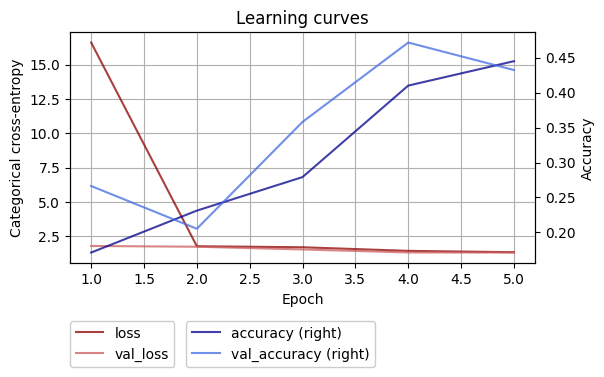

In [28]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** changing the optimizer to the Adam one, we have at epoch 5 less than 1.4 of cross-entropy for both training and validation data. Regarding the accuracy for the train dataset we have 45% and 43% of accuracy for the validation dataset.

The results were again very similar to the other CNN´s however these are the worst results until now.


### 5.5 CNN - V5

Now we will change the Learning Rate to 0.1 instead of the previous 0.001, using still the same architecture and the Adam optimizer.

In [29]:
# Architecture V3 with additional layers
cnn5 = Sequential([
                   layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Flatten(),
                   layers.Dense(units=256, activation="relu"),
                   layers.Dropout(0.5),
                   layers.Dense(units=6, activation="softmax")],
                   name="CNN-V5")
cnn5.summary()

Model: "CNN-V5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 85, 85, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 85, 85, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 42, 42, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 42, 42, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 21, 21, 64)       0         
 g2D)                                                       

Compiles and fits the model.

In [30]:
# Compile the model
cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.1),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 5
history2 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 59s 4s/step - loss: 1535366272.0000 - accuracy: 0.1756 - AUROC: 0.4969 - val_loss: 1.8179 - val_accuracy: 0.1528 - val_AUROC: 0.4873
Epoch 2/5
15/15 [==============================] - 64s 4s/step - loss: 1.8167 - accuracy: 0.1559 - AUROC: 0.5062 - val_loss: 1.8011 - val_accuracy: 0.1528 - val_AUROC: 0.4852
Epoch 3/5
15/15 [==============================] - 56s 4s/step - loss: 1.8016 - accuracy: 0.1636 - AUROC: 0.4971 - val_loss: 1.7975 - val_accuracy: 0.1528 - val_AUROC: 0.4948
Epoch 4/5
15/15 [==============================] - 59s 4s/step - loss: 1.7990 - accuracy: 0.1614 - AUROC: 0.4858 - val_loss: 1.7921 - val_accuracy: 0.1747 - val_AUROC: 0.4969
Epoch 5/5
15/15 [==============================] - 60s 4s/step - loss: 1.7978 - accuracy: 0.1636 - AUROC: 0.4784 - val_loss: 1.7938 - val_accuracy: 0.1528 - val_AUROC: 0.4939


Plotting the Learning Curves

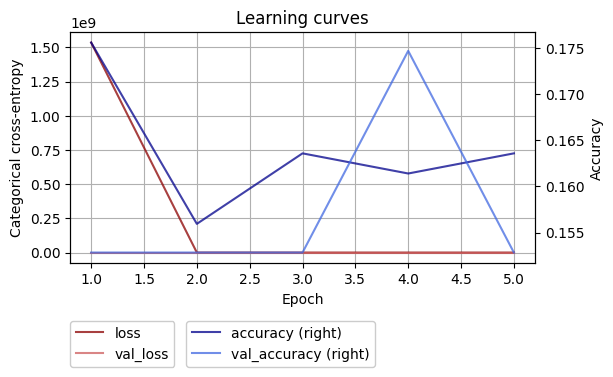

In [31]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** this time changing the learning rate from 0.001 to 0.1 was a bad choice, because the results only got worst. Both accuracy are less than 16,5% and the entrophy is around 1.8 at epoch 5. This is the worst result so far. So we will keep trying with the previous Learning Rate.




### 5.6 CNN - V6

In this example, we've reduced the number of filters in the first two Conv2D layers from 32 to 16, and increased the kernel size from 3x3 to 5x5. We've also left the number of filters and kernel size the same in the third and fourth Conv2D layers.

In [42]:
# Architecture V6 with modified filters and kernels
cnn6 = Sequential([
                   layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu", padding="same"),
                   layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Flatten(),
                   layers.Dense(units=256, activation="relu"),
                   layers.Dropout(0.5),
                   layers.Dense(units=6, activation="softmax")],
                   name="CNN-V6")
cnn6.summary()


Model: "CNN-V6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 85, 85, 16)        1216      
                                                                 
 conv2d_41 (Conv2D)          (None, 85, 85, 16)        6416      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 42, 42, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 42, 42, 32)        4640      
                                                                 
 conv2d_43 (Conv2D)          (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 21, 21, 32)       0         
 g2D)                                                       

Compiles and fits the model.

In [43]:
# Compile the model
cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 5
history2 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 41s 3s/step - loss: 12.8583 - accuracy: 0.1985 - AUROC: 0.5209 - val_loss: 1.7714 - val_accuracy: 0.1790 - val_AUROC: 0.6166
Epoch 2/5
15/15 [==============================] - 37s 2s/step - loss: 1.6558 - accuracy: 0.2988 - AUROC: 0.6616 - val_loss: 1.6675 - val_accuracy: 0.3493 - val_AUROC: 0.7201
Epoch 3/5
15/15 [==============================] - 37s 2s/step - loss: 1.4416 - accuracy: 0.4133 - AUROC: 0.7600 - val_loss: 1.3410 - val_accuracy: 0.4367 - val_AUROC: 0.7935
Epoch 4/5
15/15 [==============================] - 37s 2s/step - loss: 1.4015 - accuracy: 0.4308 - AUROC: 0.7816 - val_loss: 1.2963 - val_accuracy: 0.4454 - val_AUROC: 0.7997
Epoch 5/5
15/15 [==============================] - 40s 3s/step - loss: 1.2140 - accuracy: 0.5082 - AUROC: 0.8401 - val_loss: 1.2472 - val_accuracy: 0.4847 - val_AUROC: 0.8187


Plotting the Learning Curves 

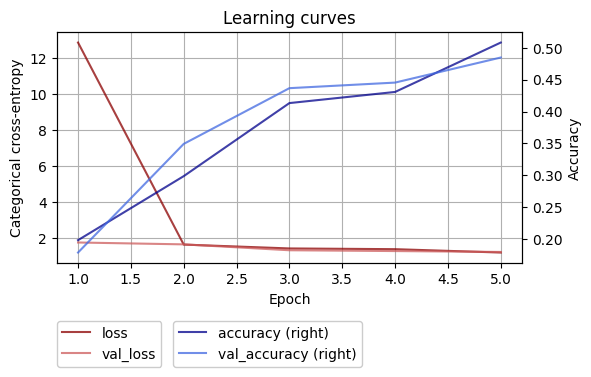

In [44]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** reducing the number of filters in the first two Conv2D layers from 32 to 16, and increasing the kernel size from 3x3 to 5x5, was a good idea. It gave us a good result with less than 1.3 to both of cross entropy at epoch 5 with 51% of accuraccy to the train set and 49% to the validation set. 


### 5.7 CNN - V7

In this example, we've added batch normalization layers after each Conv2D layer to normalize the convolved features. We've also applied L2 regularization to the kernel weights of each Conv2D and Dense layer to prevent overfitting.

In [38]:
cnn7 = Sequential([
                   layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
                                kernel_regularizer=regularizers.l2(0.001)),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
                                kernel_regularizer=regularizers.l2(0.001)),
                   layers.BatchNormalization(),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same",
                                kernel_regularizer=regularizers.l2(0.001)),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same",
                                kernel_regularizer=regularizers.l2(0.001)),
                   layers.BatchNormalization(),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same",
                                kernel_regularizer=regularizers.l2(0.001)),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same",
                                kernel_regularizer=regularizers.l2(0.001)),
                   layers.BatchNormalization(),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Flatten(),
                   layers.Dense(units=256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
                   layers.Dropout(0.5),
                   layers.Dense(units=6, activation="softmax")],
                   name="CNN-V7")
cnn7.summary()


Model: "CNN-V7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 85, 85, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 85, 85, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_35 (Conv2D)          (None, 85, 85, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 85, 85, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 42, 42, 32)       0         
 g2D)                                                            
                                                            

Compiles and fits the model.

In [40]:
# Compile the model
cnn7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 5
history2 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 93s 6s/step - loss: 2.6590 - accuracy: 0.5267 - AUROC: 0.8199 - val_loss: 2.1090 - val_accuracy: 0.5721 - val_AUROC: 0.8620
Epoch 2/5
15/15 [==============================] - 72s 5s/step - loss: 1.8379 - accuracy: 0.6543 - AUROC: 0.9167 - val_loss: 2.4776 - val_accuracy: 0.5459 - val_AUROC: 0.8402
Epoch 3/5
15/15 [==============================] - 68s 5s/step - loss: 1.6814 - accuracy: 0.7296 - AUROC: 0.9408 - val_loss: 2.1376 - val_accuracy: 0.5633 - val_AUROC: 0.8717
Epoch 4/5
15/15 [==============================] - 69s 5s/step - loss: 1.5496 - accuracy: 0.7644 - AUROC: 0.9528 - val_loss: 1.8908 - val_accuracy: 0.6245 - val_AUROC: 0.9009
Epoch 5/5
15/15 [==============================] - 76s 5s/step - loss: 1.3842 - accuracy: 0.7993 - AUROC: 0.9692 - val_loss: 2.1948 - val_accuracy: 0.5764 - val_AUROC: 0.8774


Plotting the Learning Curves

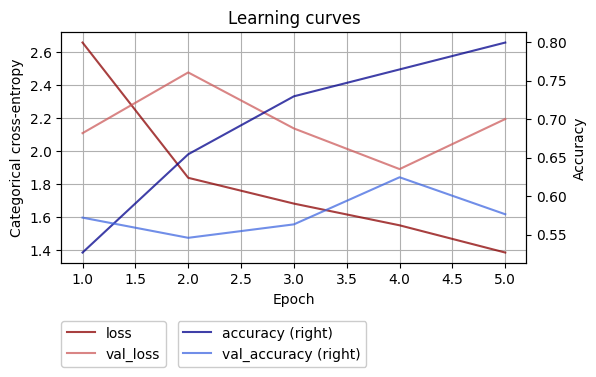

In [41]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** the addition of batch normalization layers after each Conv2D layer to normalize the convolved features, the application of L2 regularization to the kernel weights of each Conv2D and the addition of a Dense layer to prevent overfitting, brought us interesting results. We now have more accuracy on both datasets (80% for the training dataset and 58% for the validation dataset). Although this model is far from being the perfect model, this is the best model we have so far.

**For this reason we will keep the CNN-V7 as our final model in this greedy iterative manner of building a sequential model.**